## **I. Google Colab Initializtion (Only on Colab)**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# cur_dir = "/content/drive/Othercomputers/My laptop/POLIMI/AN2DL/AN2DL_CH_2/Notebooks"
# %cd $cur_dir


In [2]:
#%pip install torchview

## **1. Import Libraries**

In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
from scipy import ndimage
from PIL import Image

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

'pkill' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


PyTorch version: 2.5.1
Device: cuda


## **2. Preprocessing**

- Preprocessing pipeline : 
    - Get Loaded Images
    - Create Goo Masks
    - Apply Goo Removal + Resizing
    - Discard Shrek Images
    - Apply the external Masks (optional)
    

### 2.1 Preprocessing Functions

#### 2.1.1 _get_smart_goo_mask

In [4]:
def _get_smart_goo_mask(img_bgr):
    """
    Internal helper to detect goo using Core & Shell logic + 1px Nudge.
    Returns a binary mask (White = Goo, Black = Safe).
    """
    # 1. Convert to HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define Ranges
    # CORE: Solid Green (Strict)
    core_lower = np.array([35, 100, 50])
    core_upper = np.array([85, 255, 255])
    
    # SHELL: Faint Halo (Loose/Transparent)
    shell_lower = np.array([30, 30, 30])
    shell_upper = np.array([95, 255, 255])

    # 3. Create initial masks
    mask_core = cv2.inRange(hsv, core_lower, core_upper)
    mask_shell = cv2.inRange(hsv, shell_lower, shell_upper)

    # 4. Smart Combine (Connected Components)
    # Keep 'Shell' blobs ONLY if they touch 'Core' blobs
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_shell, connectivity=8)
    smart_mask = np.zeros_like(mask_core)

    for label_id in range(1, num_labels): # Skip background (0)
        blob_mask = (labels == label_id).astype(np.uint8) * 255
        
        # Check overlap with Core
        overlap = cv2.bitwise_and(blob_mask, mask_core)
        
        # If there is ANY overlap, keep the blob
        if cv2.countNonZero(overlap) > 0:
            smart_mask = cv2.bitwise_or(smart_mask, blob_mask)

    # 5. Fill Holes (in case the goo has shiny reflections)
    contours, _ = cv2.findContours(smart_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_filled_mask = np.zeros_like(smart_mask)
    for contour in contours:
        # Minimum area filter (200px) to remove tiny stray noise
        if cv2.contourArea(contour) > 200:
            cv2.drawContours(final_filled_mask, [contour], -1, (255), thickness=cv2.FILLED)

    # 6. The "1-Pixel Nudge"
    # Safely expand by 1 pixel to cover the final anti-aliased fringe
    kernel = np.ones((3, 3), np.uint8)
    final_expanded_mask = cv2.dilate(final_filled_mask, kernel, iterations=1)

    return final_expanded_mask



#### 2.1.2 remove_goo

In [5]:
def remove_goo(input_dir, output_dir, target_size=(224, 224), remove_goo=True, save_masks=True, replacement_color=(0, 0, 0)):
    """
    Iterates through input_dir, finds 'img_xxxx', resizes them to target_size, 
    and saves the result to output_dir.
    If remove_goo is True, it replaces green pixels (using Smart Core/Shell logic) with replacement_color.
    replacement_color: Tuple of (B, G, R) values. Default is black (0, 0, 0).
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Removing Goo from Images", unit="img"):
        output_path = output_dir / file_path.name
        
        if output_path.exists():
            # Skip silently
            continue

        img = cv2.imread(str(file_path))
        if img is None:
            continue
            
        if target_size is not None:
            img = cv2.resize(img, target_size)
            
        if remove_goo:
            # --- NEW SMART GOO LOGIC ---
            # Get the smart mask (White = Goo)
            goo_mask = _get_smart_goo_mask(img)
            
            # Invert Goo Mask (White = Safe)
            not_goo_mask = cv2.bitwise_not(goo_mask)
            
            # Apply Mask to keep safe areas (Goo areas become black/0)
            img_safe = cv2.bitwise_and(img, img, mask=not_goo_mask)
            
            # Create background with replacement color
            bg = np.full_like(img, replacement_color)
            
            # Keep background only where Goo is
            bg_goo = cv2.bitwise_and(bg, bg, mask=goo_mask)
            
            # Combine: Safe Image + Colored Goo Areas
            img = cv2.add(img_safe, bg_goo)

            if save_masks:
                # Save the mask (White = Safe/Tissue, Black = Goo)
                mask_name = file_path.name.replace('img_', 'goo_mask_', 1)
                mask_output_path = os.path.join(output_dir, "goo_masks", mask_name)
                Path(os.path.dirname(mask_output_path)).mkdir(parents=True, exist_ok=True)
                cv2.imwrite(str(mask_output_path), not_goo_mask)
            
        cv2.imwrite(str(output_path), img)
        count += 1

    print(f"Resizing complete. Processed {count} new images.")

#### 2.1.3 clean_and_save_masks

In [6]:
def clean_and_save_masks(goo_masks_dir, external_masks_dir, output_dir, target_size=(224, 224)):
    """
    Loads goo masks (White=Safe) generated by remove_goo and original external masks.
    Removes goo areas from external masks (intersection of Safe and External).
    Saves the cleaned masks to output_dir.
    TODO: Add check for if the masks already exist to skip processing.
    """
    goo_masks_dir = Path(goo_masks_dir)
    external_masks_dir = Path(external_masks_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Find all goo masks
    goo_mask_files = list(goo_masks_dir.glob('goo_mask_*.png'))
    
    if not goo_mask_files:
        print(f"No goo masks found in {goo_masks_dir}")
        return

    print(f"Found {len(goo_mask_files)} goo masks. Processing...")

    count = 0
    for goo_mask_path in tqdm(goo_mask_files, desc="Cleaning External Masks"):
        # Derive external mask filename: goo_mask_xxxx.png -> mask_xxxx.png
        mask_name = goo_mask_path.name.replace('goo_mask_', 'mask_', 1)
        external_mask_path = external_masks_dir / mask_name
        
        # Fallback: check for .png if not found (though goo_mask is .png)
        if not external_mask_path.exists():
             # Try finding with same stem but different extension if needed
             pass

        if not external_mask_path.exists():
            # tqdm.write(f"External mask not found for {goo_mask_path.name}")
            continue

        # Load masks
        # Goo mask: White = Safe, Black = Goo
        goo_mask = cv2.imread(str(goo_mask_path), cv2.IMREAD_GRAYSCALE)
        # External mask: White = ROI, Black = Background
        external_mask = cv2.imread(str(external_mask_path), cv2.IMREAD_GRAYSCALE)

        if goo_mask is None or external_mask is None:
            continue

        # Resize external mask if target_size is provided
        # Note: goo_mask is already at the size produced by remove_goo
        if target_size is not None:
             external_mask = cv2.resize(external_mask, target_size, interpolation=cv2.INTER_NEAREST)
             # Ensure goo_mask matches if it wasn't already (e.g. if remove_goo used different settings)
             if goo_mask.shape[:2] != (target_size[1], target_size[0]):
                 goo_mask = cv2.resize(goo_mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Ensure binary (0 or 255)
        _, external_mask = cv2.threshold(external_mask, 127, 255, cv2.THRESH_BINARY)
        _, goo_mask = cv2.threshold(goo_mask, 127, 255, cv2.THRESH_BINARY)

        # Combine: Result is White only if BOTH are White
        # i.e. It is in the External Mask AND it is Safe (not goo)
        cleaned_mask = cv2.bitwise_and(external_mask, goo_mask)

        # Save
        output_path = output_dir / mask_name
        cv2.imwrite(str(output_path), cleaned_mask)
        count += 1

    print(f"Cleaned masks saved to {output_dir}. Processed {count} masks.")

#### 2.1.4 apply_mask

In [7]:
def apply_mask(image_path, mask_path, output_path, target_size=(224, 224), remove_goo=True):
    """
    Loads an image and a mask. 
    If remove_goo is True, it subtracts green pixels (using Smart Core/Shell logic) 
    from the valid mask area. Resizes and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load External Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        img = cv2.resize(img, target_size)
        mask = cv2.resize(mask, target_size)

    # 4. Standardize External Mask (Binary 0 or 255)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Determine Final Mask
    if remove_goo:
        # --- NEW SMART GOO LOGIC ---
        # Get the smart mask (White = Goo)
        goo_mask = _get_smart_goo_mask(img)
        
        # Invert Goo Mask (White = Safe)
        not_goo_mask = cv2.bitwise_not(goo_mask)
        
        # Combine: Must be Tissue (binary_mask) AND Safe (not_goo_mask)
        final_mask = cv2.bitwise_and(binary_mask, not_goo_mask)
    else:
        # --- ORIGINAL LOGIC ---
        final_mask = binary_mask

    # 6. Apply Final Mask
    # Areas outside the final mask become Black (0)
    masked_img = cv2.bitwise_and(img, img, mask=final_mask)

    # 7. Save result
    # Ensure output directory exists
    os.makedirs(os.path.dirname(str(output_path)), exist_ok=True)
    cv2.imwrite(str(output_path), masked_img)

#### 2.1.5 filter_bright_green_areas

In [8]:
def filter_bright_green_areas(image, lg_H=20, lg_S=45, lg_V=0, ug_H=84, ug_S=255, ug_V=255, dilate_iterations=2):
    """
    Filters out bright green areas from the input image with improved residual removal.
    
    Args:
        image: Input image in RGB format (0-1 range)
        lg_H, lg_S, lg_V: Lower bounds for HSV green detection
        ug_H, ug_S, ug_V: Upper bounds for HSV green detection
        dilate_iterations: Number of dilation iterations to expand mask (removes edge artifacts)
    """

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    lower_green = (lg_H, lg_S, lg_V)
    upper_green = (ug_H, ug_S, ug_V)

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # OPEN: Remove small noise
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # DILATE: Expand the mask to catch edge artifacts and residuals
    # This ensures we remove green pixels at the boundaries
    if dilate_iterations > 0:
        clean_mask = cv2.dilate(clean_mask, kernel, iterations=dilate_iterations)

    # 4. Additional step: Detect any remaining green-ish pixels
    # Create a more aggressive mask for subtle green tones
    lower_green_subtle = (max(0, lg_H - 10), max(0, lg_S - 10), 0)
    upper_green_subtle = (min(180, ug_H + 10), 255, 255)
    subtle_mask = cv2.inRange(hsv, lower_green_subtle, upper_green_subtle)
    
    # Only keep subtle green pixels that are near the main green area
    subtle_mask = cv2.morphologyEx(subtle_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(clean_mask, subtle_mask)

    # 5. Invert mask to keep the useful parts
    mask_inv = cv2.bitwise_not(combined_mask)

    # 6. Apply the mask
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, combined_mask

#### 2.1.6 analyze_dataset_for_shreks

In [9]:
def analyze_dataset_for_shreks(directory, ratio_threshold=0.0125):
    shrek_images = []
    tissue_images = []
    
    image_files = glob.glob(os.path.join(directory, 'img_*.png'))
    print(f"Found {len(image_files)} images in {directory}")

    for f in tqdm(image_files, desc="Analyzing for Shreks"):
        try:
            # Load image (BGR)
            img = cv2.imread(f)
            if img is None: continue
            
            # Prepare image for the new filter: Convert BGR to RGB (0-1 float)
            img_rgb_norm = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            
            # Apply Filter
            result_bgr, mask = filter_bright_green_areas(img_rgb_norm)
            
            # Calculate Ratio of Green Pixels from the combined mask
            total_pixels = img.shape[0] * img.shape[1]
            green_pixels = np.count_nonzero(mask)
            ratio = green_pixels / total_pixels
            
            # Convert BGR to RGB for plotting
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            entry = {
                'name': os.path.basename(f), 
                'path': f,
                'img': img_rgb, 
                'ratio': ratio,
                'mask': mask
            }

            # === CLASSIFICATION LOGIC ===
            if ratio > ratio_threshold:
                shrek_images.append(entry)
            else:
                tissue_images.append(entry)
                
        except Exception as e:
            print(f"Skipping {f}: {e}")

    return shrek_images, tissue_images

#### 2.1.7 process_batch

In [10]:
def process_batch(input_dir, output_dir, target_size=(224, 224), remove_goo=True):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx'.
    Passes the remove_goo flag to the apply_mask function.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    output_dir.mkdir(parents=True, exist_ok=True)
    
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    count = 0
    
    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct mask filename
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name
        
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")
        
        if mask_path.exists():
            output_path = output_dir / file_path.name
            
            if output_path.exists():
                continue

            # Pass the remove_goo flag here
            apply_mask(file_path, mask_path, output_path, target_size=target_size, remove_goo=remove_goo)
            count += 1
        else:
            tqdm.write(f"Skipping {file_path.name}: No matching mask found.")

    print(f"Batch processing complete. Processed {count} new images.")



#### 2.1.8 process_classification_results

In [11]:
def process_classification_results(shrek_list, tissue_list, shrek_dir, tissue_dir, threshold, visualize = True):
    """
    Saves classified images to respective directories and visualizes the results.
    
    Args:
        shrek_list (list): List of dicts containing Shrek image data.
        tissue_list (list): List of dicts containing Tissue image data.
        shrek_dir (str): Path to save Shrek images.
        tissue_dir (str): Path to save Tissue images.
        threshold (float): The green ratio threshold used for classification.
    """
    
    # 1. Print Summary
    print(f"Classified {len(shrek_list)} as Shrek")
    print(f"Classified {len(tissue_list)} as Tissue")

    # Ensure directories exist
    os.makedirs(shrek_dir, exist_ok=True)
    os.makedirs(tissue_dir, exist_ok=True)

    # 2. Save Shrek images
    print(f"Saving {len(shrek_list)} Shrek images to {shrek_dir}...")
    for item in tqdm(shrek_list, desc="Saving Shrek Images"):
        dest_path = os.path.join(shrek_dir, item['name'])
        
        # Check if file exists to prevent overwriting
        if os.path.exists(dest_path):
            continue

        try:
            shutil.copy2(item['path'], dest_path)
        except Exception as e:
            print(f"Error copying {item['name']} to shrek folder: {e}")

    # 3. Save Tissue images
    print(f"Saving {len(tissue_list)} Tissue images to {tissue_dir}...")
    for item in tqdm(tissue_list, desc="Saving Tissue Images"):
        dest_path = os.path.join(tissue_dir, item['name'])
        
        # Check if file exists to prevent overwriting
        if os.path.exists(dest_path):
            continue

        try:
            shutil.copy2(item['path'], dest_path)
        except Exception as e:
            print(f"Error copying {item['name']} to tissue folder: {e}")
    if visualize == True:
        # 4. Visualize Examples (2x2 Grid)
        if len(shrek_list) >= 2 and len(tissue_list) >= 2:
            fig_ex, axes = plt.subplots(2, 2, figsize=(12, 10))
            fig_ex.suptitle(f"Classification Results (Threshold: {threshold:.1%})", fontsize=16)

            def show_img(ax, item, label):
                ax.imshow(item['img'])
                # Show the Green Ratio in the title so you can see WHY it was classified
                ax.set_title(f"{label}\n{item['name']}\nGreen Pixels: {item['ratio']:.2%}")
                ax.axis('off')

            # Row 1: Detected Shrek
            show_img(axes[0, 0], shrek_list[0], "Detected Shrek")
            show_img(axes[0, 1], shrek_list[1], "Detected Shrek")

            # Row 2: Detected Tissue
            show_img(axes[1, 0], tissue_list[0], "Detected Tissue")
            show_img(axes[1, 1], tissue_list[1], "Detected Tissue")

            plt.tight_layout()
            plt.show()
        else:
            print("Not enough images in one or both classes to generate 2x2 sample grid.")

        # 5. Plot Scatter Distribution for Tuning
        shrek_ratios = [x['ratio'] for x in shrek_list]
        tissue_ratios = [x['ratio'] for x in tissue_list]

        plt.figure(figsize=(12, 6))

        # Plot Tissue points (Blue)
        plt.scatter(range(len(tissue_ratios)), tissue_ratios, color='blue', alpha=0.6, label='Classified as Tissue')

        # Plot Shrek points (Green) - Shifted on x-axis to be distinct
        # We shift the x-axis index for Shrek so they appear after the tissue points
        plt.scatter(range(len(tissue_ratios), len(tissue_ratios) + len(shrek_ratios)), shrek_ratios, color='green', alpha=0.6, label='Classified as Shrek')

        # Draw the Threshold Line
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.1%})')

        plt.title('Green Pixel Ratio per Image', fontsize=14)
        plt.ylabel('Ratio of Green Pixels (0.0 - 1.0)')
        plt.xlabel('Image Index')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Shrek removal visulization OFF.")

# --- Example Usage ---
# shrek_list, tissue_list = analyze_dataset(DATASET_PATH) # Assuming this runs before
# process_classification_results(shrek_list, tissue_list, SHREK_DIR, TISSUE_DIR, RATIO_THRESHOLD)

#### 2.1.9 copy_masks

In [12]:
def copy_masks(image_list, masks_dir, output_dir):
    image_names = image_list
    mask_names = [name.replace('img_', 'mask_', 1) for name in image_names]

    for mask_name in tqdm(mask_names, desc="Copying Masks"):
        src_path = os.path.join(masks_dir, mask_name)
        dst_path = os.path.join(output_dir, mask_name)
        shutil.copy(src_path, dst_path)
    
    return

#### 2.1.10 extract_smart_patches

In [13]:
def extract_smart_patches(img_path, mask_path, patch_size=224, stride=224, threshold=0.30):
    """
    Intelligently extracts patches. 
    UPDATED: Groups nearby tumor spots and centers the patch on the region.
    """
    # Load images
    try:
        img = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        # Fallback for common extension swap if .png not found
        if img_path.endswith(".png"):
            img = Image.open(img_path.replace(".png", ".jpg")).convert("RGB")
        else:
            raise

    mask = Image.open(mask_path).convert("L")
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # Normalize mask
    if mask_arr.max() <= 1:
        mask_check = mask_arr * 255
    else:
        mask_check = mask_arr
    
    h, w, _ = img_arr.shape
    
    if isinstance(patch_size, int):
        ph, pw = patch_size, patch_size
    else:
        ph, pw = patch_size
        
    if isinstance(stride, int):
        sh, sw = stride, stride
    else:
        sh, sw = stride

    # --- Intelligent Extraction Logic ---
    
    # 1. GROUPING: Dilate the mask to merge nearby small dots into larger regions.
    # This prevents generating 1 patch per pixel-sized dot.
    # iterations=15 means dots within ~15 pixels of each other get merged.
    dilated_mask = ndimage.binary_dilation(mask_check > 128, iterations=15)
    
    # 2. Label the merged regions
    labeled_mask, num_features = ndimage.label(dilated_mask)
    objects = ndimage.find_objects(labeled_mask)
    
    candidate_coords = set()
    
    def get_valid_start(val, max_val, p_dim):
        return max(0, min(val, max_val - p_dim))

    # print(f"Found {num_features} clustered tumor regions.") # Commented out for batch processing

    for i, slice_obj in enumerate(objects):
        y_slice, x_slice = slice_obj
        
        # Region boundaries
        y_min, y_max = y_slice.start, y_slice.stop
        x_min, x_max = x_slice.start, x_slice.stop
        
        # --- Strategy: Center on Blob ---
        # We calculate the center of the blob and place the patch there.
        
        blob_cy = (y_min + y_max) // 2
        blob_cx = (x_min + x_max) // 2
        
        # Top-left corner for the patch to be centered on the blob center
        start_y = blob_cy - ph // 2
        start_x = blob_cx - pw // 2
        
        valid_y = get_valid_start(start_y, h, ph)
        valid_x = get_valid_start(start_x, w, pw)
        
        candidate_coords.add((valid_x, valid_y))

    # 3. Final Validation
    patches = []
    coords = []
    
    for (x, y) in candidate_coords:
        mask_patch = mask_check[y:y+ph, x:x+pw]
        img_patch = img_arr[y:y+ph, x:x+pw]
        
        # Use Tissue Threshold (non-white pixels)
        img_gray = np.mean(img_patch, axis=2)
        tissue_ratio = np.sum(img_gray < 235) / (ph * pw)
        
        # Use Mask Threshold (tumor pixels)
        mask_ratio = np.sum(mask_patch > 128) / (ph * pw)
        
        # Keep patch only if it has enough tumor AND enough tissue
        if mask_ratio >= threshold and tissue_ratio > 0.15:
            patches.append(img_patch)
            coords.append((x, y))

    return patches, coords, img_arr, mask_arr

#### 2.1.11 create_patches_dataset

In [14]:
def create_patches_dataset(input_dir, output_dir, mask_dir, patch_size=224, stride=224, threshold=0.30):
    """
    Iterates over images in input_dir, finds corresponding masks in mask_dir, 
    extracts smart patches, and saves them to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    mask_dir = Path(mask_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Filter for image files
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in {'.png', '.jpg', '.jpeg'}
    ]
    
    count = 0
    print(f"Starting patch extraction from {input_dir} to {output_dir} using masks from {mask_dir}...")
    
    for file_path in tqdm(image_files, desc="Extracting Patches"):
        # Construct mask filename (assuming mask_xxxx.png matches img_xxxx.png)
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = mask_dir / mask_name
        
        # Fallback if mask has different extension or wasn't found
        if not mask_path.exists():
             mask_path = mask_dir / (file_path.stem.replace('img_', 'mask_', 1) + ".png")

        if mask_path.exists():
            # Extract patches
            patches, coords, _, _ = extract_smart_patches(
                str(file_path), 
                str(mask_path), 
                patch_size=patch_size, 
                stride=stride, 
                threshold=threshold
            )
            
            # Save each patch
            base_name = file_path.stem
            for i, patch in enumerate(patches):
                # patch is a numpy array (H, W, 3), convert to PIL Image to save
                patch_img = Image.fromarray(patch)
                
                # Construct a unique filename for the patch
                save_name = f"{base_name}_p{i}.png"
                patch_img.save(output_dir / save_name)
                count += 1
        else:
            # Optional: Print if mask is missing
            # tqdm.write(f"Mask not found for {file_path.name}")
            pass
            
    print(f"Extraction complete. Saved {count} patches to {output_dir}")

# --- Execute Patch Extraction ---
# We use TISSUE_OUT because it contains the images we want to process (after goo/shrek removal)
# and their corresponding masks (copied in step 3).

### 2.2 Run Preprocessing

In [15]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = test_data_path

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
# preprocessing output paths
#preprocessing step 1 output path
GOO_REMOVAL_OUT = os.path.join(datasets_path, "test_nogoo")

#preprocessing step 2 output path
SHREK_REMOVAL_OUT = os.path.join(datasets_path, "test_noshreks")
SHREKS_OUT = os.path.join(SHREK_REMOVAL_OUT, "test_shreks")
TISSUE_OUT = os.path.join(SHREK_REMOVAL_OUT, "test_tissue")

#preprocessing step 3 output path
FINAL_TRAIN_OUT = os.path.join(datasets_path, "test_masked_noshreks")
  # Where the resized unmasked images will be saved
PATCHES_OUT = os.path.join(datasets_path, "test_patches")

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ..\an2dl2526c2
Train data path: ..\an2dl2526c2\train_data
Train labels path: ..\an2dl2526c2\train_labels.csv
Test data path: ..\an2dl2526c2\test_data


In [16]:
# Step 1: Remove goo and do not resize images
remove_goo(SOURCE_FOLDER,GOO_REMOVAL_OUT, target_size=None, remove_goo=True, save_masks=True, replacement_color=(195, 195, 195))

Scanning for images in: ..\an2dl2526c2\test_data...


Removing Goo from Images: 100%|██████████| 954/954 [01:33<00:00, 10.24img/s]

Resizing complete. Processed 954 new images.


In [17]:
clean_and_save_masks(
    goo_masks_dir=os.path.join(GOO_REMOVAL_OUT, "goo_masks"), 
    external_masks_dir=SOURCE_FOLDER, 
    output_dir=os.path.join(GOO_REMOVAL_OUT, "cleaned_masks"), 
    target_size=None
)

Found 954 goo masks. Processing...


Cleaning External Masks: 100%|██████████| 954/954 [00:25<00:00, 37.17it/s]

Cleaned masks saved to ..\an2dl2526c2\test_nogoo\cleaned_masks. Processed 954 masks.


In [18]:
#Step 2: Discard Shrek Images
shreks_list, tissue_list = analyze_dataset_for_shreks(GOO_REMOVAL_OUT, ratio_threshold=0.0125)

process_classification_results(shreks_list, tissue_list, SHREKS_OUT, TISSUE_OUT, 0.0125, visualize=False)

tissue_image_names = [item['name'] for item in tissue_list]
copy_masks(tissue_image_names, SOURCE_FOLDER, TISSUE_OUT)

# Clean up memory
del shreks_list
del tissue_list
gc.collect()

Found 954 images in ..\an2dl2526c2\test_nogoo


Analyzing for Shreks: 100%|██████████| 954/954 [01:24<00:00, 11.35it/s]


Classified 0 as Shrek
Classified 954 as Tissue
Saving 0 Shrek images to ..\an2dl2526c2\test_noshreks\test_shreks...


Saving Shrek Images: 0it [00:00, ?it/s]


Saving 954 Tissue images to ..\an2dl2526c2\test_noshreks\test_tissue...


Saving Tissue Images: 100%|██████████| 954/954 [00:02<00:00, 366.62it/s]


Shrek removal visulization OFF.


Copying Masks: 100%|██████████| 954/954 [00:00<00:00, 1106.48it/s]


9

In [19]:
CLEANED_MASKS_DIR = os.path.join(GOO_REMOVAL_OUT, "cleaned_masks")
create_patches_dataset(
    TISSUE_OUT, 
    PATCHES_OUT, 
    mask_dir=CLEANED_MASKS_DIR,
    patch_size=224, 
    stride=224, 
    threshold=0.01
)

Starting patch extraction from ..\an2dl2526c2\test_noshreks\test_tissue to ..\an2dl2526c2\test_patches using masks from ..\an2dl2526c2\test_nogoo\cleaned_masks...


Extracting Patches: 100%|██████████| 954/954 [01:49<00:00,  8.72it/s]

Extraction complete. Saved 4210 patches to ..\an2dl2526c2\test_patches


## **3. Load Images From Folder**

In [20]:
def load_images_from_folder(folder, resize=None, filter_prefix=None):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images
        resize (tuple): Target size (width, height) or None
        filter_prefix (str): Prefix to filter filenames (e.g. 'img_')

    Returns:
        tuple: (np.ndarray of images, list of filenames)
    """
    images = []
    loaded_filenames = []
    
    # Get the list of files to iterate over
    file_list = sorted(os.listdir(folder))
    
    # Filter files before iterating to show correct progress
    if filter_prefix:
        file_list = [f for f in file_list if f.startswith(filter_prefix)]

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            # print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        if resize:
            img = cv2.resize(img, resize)

        images.append(img)
        loaded_filenames.append(filename)

    return np.array(images), loaded_filenames

In [21]:
# Load masked images (already resized in process_batch)
# We add filter_prefix='img_' to ensure we don't load any mask files that might be in the folder
masked_images, masked_filenames = load_images_from_folder(PATCHES_OUT, filter_prefix='img_')

train_images = masked_images

filenames = masked_filenames


print(f"Loaded {len(masked_images)} masked images.")
print(f"Total images: {len(train_images)}")

Loading images from test_patches: 100%|██████████| 4210/4210 [00:43<00:00, 95.97it/s] 


Loaded 4210 masked images.
Total images: 4210


## **4. Exploration and Data Analysis**

### 4.1 Show Some Random Images

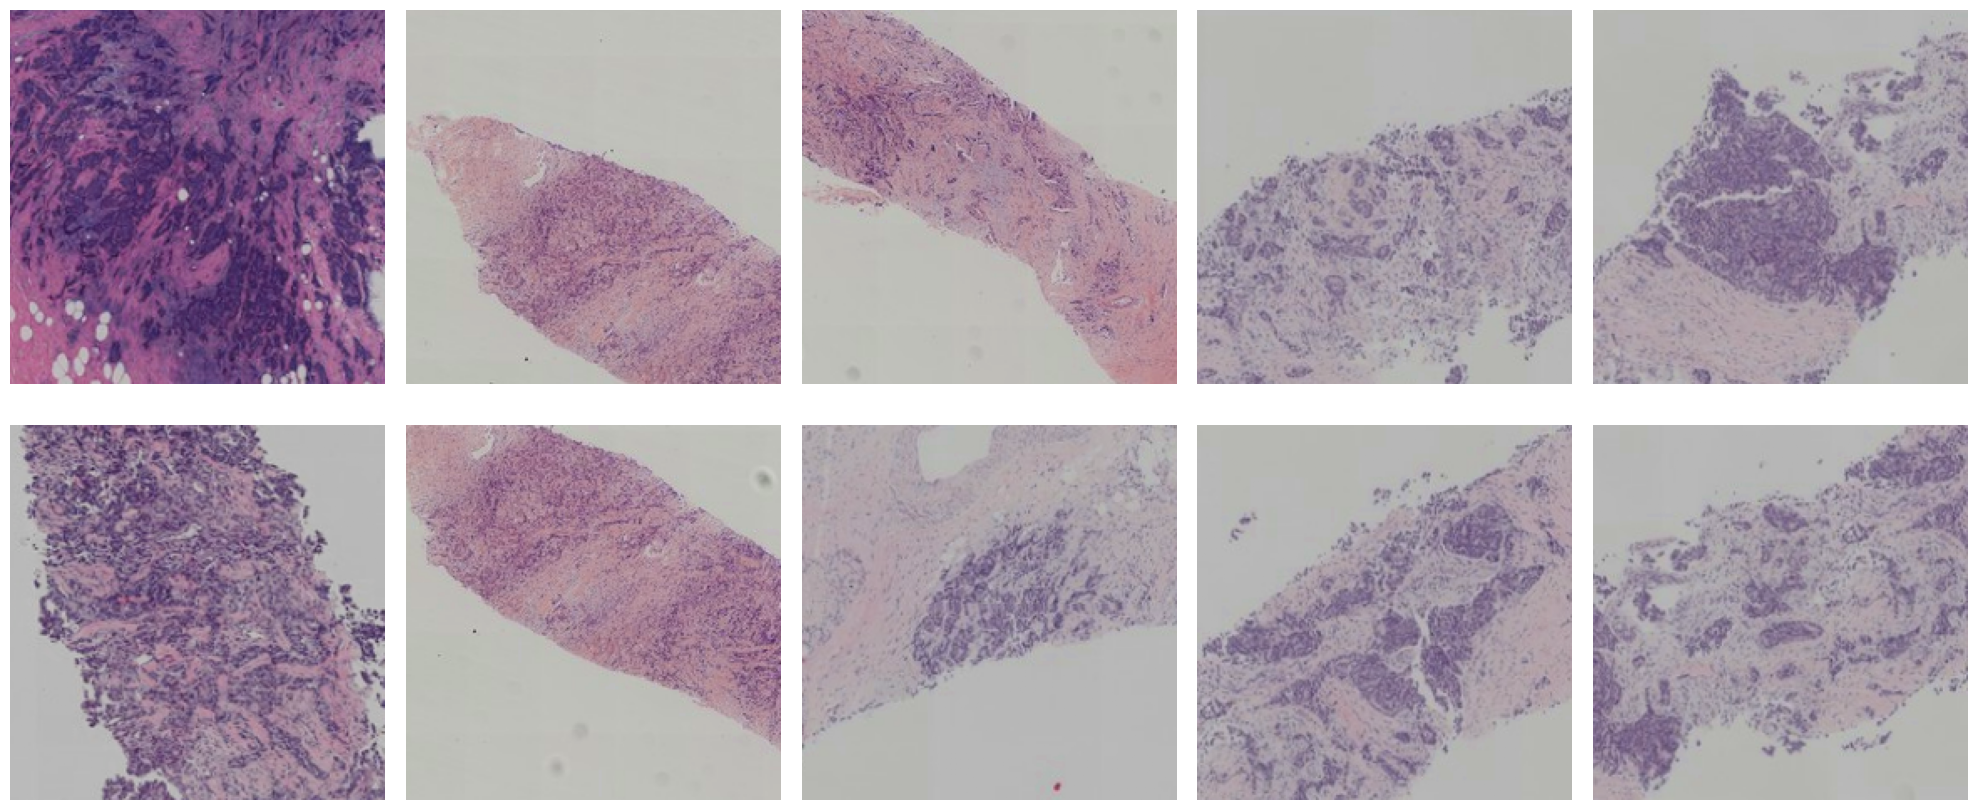

In [22]:
# Number of images to display
num_img = 10
# Starting index
start_img= random.randint(0, len(train_images) - num_img)
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()



## **5. Train/Val Split**

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit

# 1. Load the labels CSV
labels_df = pd.read_csv(train_labels_path)
# Create a dictionary mapping filename -> label for fast lookup
labels_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1]))

# 2. Get the filenames corresponding to the images loaded in Cell 7
# IMPORTANT: This must match the order used in 'load_images_from_folder' exactly.
# We use the filenames list created in the previous cell.

print("Aligning labels to loaded images...")

X_aligned = []
y_aligned = []
groups = []  # This will store the "Original Image ID" for each patch

# 3. Iterate through the filenames to sync X (images) and y (labels)
if len(filenames) != len(train_images):
    raise ValueError(f"Mismatch! Loaded images ({len(train_images)}) != Files found ({len(filenames)}).")

for i, filename in enumerate(filenames):
    # Extract original filename from patch filename to find the label and group
    # Format: img_XXXX_pY.png -> we want img_XXXX.png
    parts = filename.split('_p')
    if len(parts) > 1:
        original_stem = parts[0] # e.g., "img_0001"
        original_filename = original_stem + ".png"
    else:
        # Fallback if it's not a patch filename
        original_filename = filename

    if original_filename in labels_map:
        # If the file exists in our CSV, keep the image and the label
        X_aligned.append(train_images[i])
        y_aligned.append(labels_map[original_filename])
        groups.append(original_filename) # The group is the original image name
    else:
        # If image is in folder but NOT in CSV, we must discard the image
        # print(f"Skipping {filename}: Original {original_filename} not in CSV.")
        pass

# Convert to numpy arrays
X = np.array(X_aligned)
y = np.array(y_aligned)
groups = np.array(groups)

print(f"Images aligned: {X.shape}")
print(f"Labels aligned: {y.shape}")
print(f"Groups (Patients) aligned: {groups.shape}")

# 4. Encode labels (String -> Integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print class mapping
print("Classes:", label_encoder.classes_)

# 5. Group-Aware Train-Test Split
# We use GroupShuffleSplit to ensure all patches from the same image stay in the same set.

# First Split: Train vs Temp (Val + Test)
# We split based on 'groups', not just indices
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, temp_idx = next(gss1.split(X, y_encoded, groups))

X_train = X[train_idx]
y_train = y_encoded[train_idx]
groups_train = groups[train_idx]

X_temp = X[temp_idx]
y_temp = y_encoded[temp_idx]
groups_temp = groups[temp_idx]

# Second Split: Val vs Test (splitting the Temp set)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups_temp))

X_val = X_temp[val_idx]
y_val = y_temp[val_idx]

X_test = X_temp[test_idx]
y_test = y_temp[test_idx]

print("-" * 30)
print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

# Verify Data Leakage (Should be empty sets)
train_groups_set = set(groups_train)
val_groups_set = set(groups_temp[val_idx])
test_groups_set = set(groups_temp[test_idx])

print("-" * 30)
print(f"Leakage Train-Val (Shared Images): {train_groups_set.intersection(val_groups_set)}")
print(f"Leakage Train-Test (Shared Images): {train_groups_set.intersection(test_groups_set)}")
print(f"Leakage Val-Test (Shared Images): {val_groups_set.intersection(test_groups_set)}")

Aligning labels to loaded images...
Images aligned: (4210, 224, 224, 3)
Labels aligned: (4210,)
Groups (Patients) aligned: (4210,)
Classes: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
------------------------------
Training data shape: (3372, 224, 224, 3), Labels: (3372,)
Validation data shape: (439, 224, 224, 3), Labels: (439,)
Test data shape: (399, 224, 224, 3), Labels: (399,)
------------------------------
Leakage Train-Val (Shared Images): set()
Leakage Train-Test (Shared Images): set()
Leakage Val-Test (Shared Images): set()


### 4.1 Set Input Size and Number of Classes

In [24]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


### 4.2 Create Tensor Datasets

In [25]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

## **6. Dataloaders**

### 6.1 Set Batch Size

In [26]:
# Define the batch size
BATCH_SIZE = 64

### 6.2 make_loader Function Definition

In [27]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

### 6.3 Create Data Loaders

In [28]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [29]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Features batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
